In [1]:
# Hyperparameters
test_results = True
T = 15
N = 10
n_from_index = 0 # How distant the first point is

In [2]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_position, my_odometry


DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0, 'win32_disable_shaping': False}


In [3]:
plt.rcParams['figure.figsize'] = [7, 7]

In [4]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [5]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [6]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

In [7]:
dt = 1.0 / env.frame_rate

In [8]:
env.reset()
traj = utils.get_trajectory(env, samples=500, method="distance", last_value_distance=1.035)

/home/giulio/prog/duckrace/utils.py:316: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [9]:
pose = get_position(env)
pose

Position(x=1.8719999027252197, y=1.9297064071170351, theta=1.5707963267948966)

Text(1.9486294618007634, 1.9308421914242628, '|---------|')

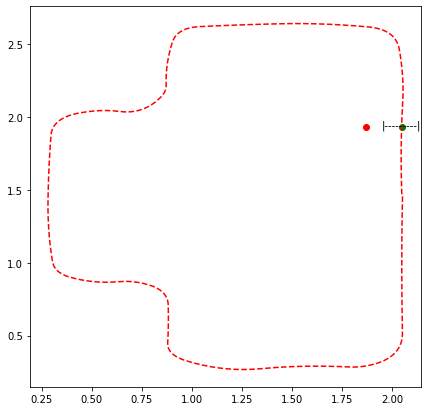

In [10]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index += n_from_index
startpoint = (traj[index,0], traj[index,1])
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")
plt.text(startpoint[0]-0.1, startpoint[1], '|'+'-'*9+'|')

In [11]:
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"

'Samples must be at least: 376.0'

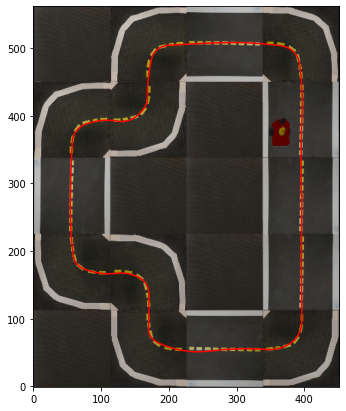

In [12]:
utils.show_on_map_array(env, traj[:,:2])

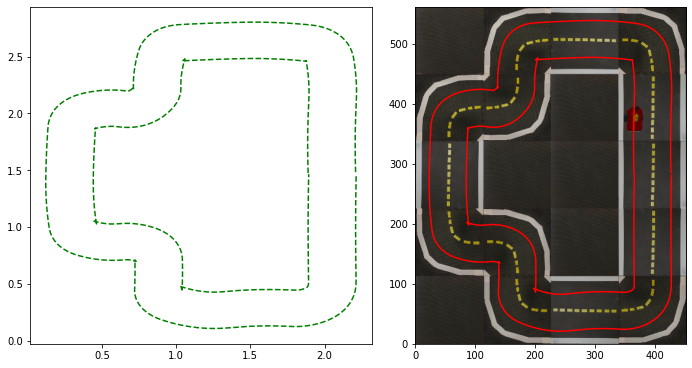

In [13]:
inside, outside = utils.get_border(traj, distance=0.16)
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AB""")
ax_dict["A"].plot(*inside.T, "g--")
ax_dict["A"].plot(*outside.T, "g--")
utils.show_on_map_array(env, inside, fig=ax_dict["B"])
utils.show_on_map_array(env, outside, fig=ax_dict["B"])

In [14]:
get_position(env)

Position(x=1.8719999027252197, y=1.9297064071170351, theta=1.5707963267948966)

In [15]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [16]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

In [17]:
traj[index]

array([2.04862946, 1.93084219, 1.54813545])

In [18]:
index = DM(index)
traj = DM(traj)
out = DM(outside)
ins = DM(inside)

Initialize states, inputs, and system dynamic equation

In [19]:
pose = get_position(env)

In [20]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

# With preview
# Initial reference point
r0 = traj[index:index+N+1, :2].T
t0 = traj[index:index+N+1, 2].T

In [21]:
F = utils.model_F(dt=dt)

In [22]:
mod = utils.casadi_mod

In [23]:
finish_line = [1.75, 0.8]

In [24]:
# K nearest neighbors
K = 10

## LMPC

In [25]:
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
l = opti.variable(1,K)      # Lambda of convex hull
z = opti.variable(1,1)      # z of the paper
x0 = opti.parameter(5,1)    # Parameter to set the initial state conditions (x(0))
D = opti.parameter(1,K)     # Nearest neighbors
J = opti.parameter(1, K)    # A matrix time, iteration with the old states

def h(x):
   # return 1 if it gets across the finish line
   # finish line is defined as the area where x > 1.75 and y is between 1.75 and 1.8
   return if_else(logic_and(x[0,0]>1.75, logic_and(x[1,0]>1.75, x[1,0]<1.8)), 0, 1)

obj = sumsqr(h(x)) + dot(J,l)

opti.minimize(obj)

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
   opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # No delay
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == x0)
# 4) Set the convex hull constraints
opti.subject_to(l >= 0)
opti.subject_to(sumsqr(l) == 1)
opti.subject_to(dot(D, l) == x[:,N])


opti.set_value(x0,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)


In [26]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[x0, D, J],[u[:,0]],['x0', 'D', 'J'],['u_opt'])

### Loop 0

In [27]:
# First loop
Mpc = Function.load('M.casadi')


# MPC loop
F = utils.model_F(dt=dt)
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
r = r0
tr = t0
idx = index
u_delay = u_delay0

kdtree = spatial.KDTree(traj[:, :2])

step = 0
while True:
    u = Mpc(x, r, tr, u_delay, 100, 5e-4, 1, 1e-3)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    if idx+N+1 < traj.shape[0]:
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    else:
        r = vertcat(traj[idx:, :2], traj[:idx+N+1-traj.shape[0], :2]).T
        tr = vertcat(traj[idx:, 2], traj[:idx+N+1-traj.shape[0], 2]).T

    if traj[idx, 0] > 1.75 and traj[idx, 1] > 1.75 and traj[idx, 1] < 1.8:
        break
    step += 1




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



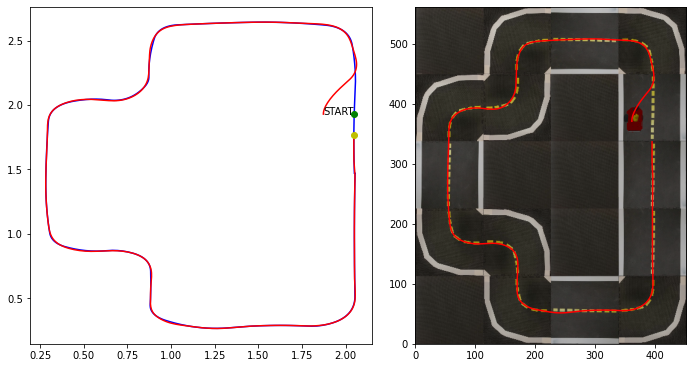

In [28]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

In [29]:
all_points = X_log.T

### Loop > 0

In [30]:
from sklearn.neighbors import NearestNeighbors

In [64]:
#IDEA:
# Trajectory 0
# Compute time in each point and subtract from total length to get arrival time
# Compute nearest neighbours to each point, store in an D with iteration number D=[x_tl1, xtl2, ..., x_tlN, ..., xtj1, xtj2, ..., xtjN] 
# Compute a matrix S that is D at time t+1: S=[x_tl1, xtl2, ..., x_tlN, ..., xtj1, xtj2, ..., xtjN]
# COMPUTE J AND PASS TO THE OPTIMIZATION

# MPC loop
F = utils.model_F(dt=dt)
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
idx = index

for iteration in range(2):
    kdtree = spatial.KDTree(traj[:, :2])
    J = idx+N
    step = 0
    while True:
        u = M(x)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        # simulate
        x = F(x,u)

        _,idx_new = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        if idx_new >= idx:
            idx = idx_new
        
        if traj[idx, 0] > 1.75 and traj[idx, 1] > 1.75 and traj[idx, 1] < 1.8:
            break
        step += 1

CasADi - 2022-03-17 14:34:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 259 (row 119, col 75).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-03-17 14:34:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 259 (row 119, col 75).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-03-17 14:34:56 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 259 (row 119, col 75).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-03-17 14:34:56 WARNING("solver:nlp_grad failed: NaN detected for output grad_gamma_p, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-03-17 14:34:56 WARNING("Failed to calculate multipliers") [.../casadi/core/nlpsol.cpp:621]


In [30]:
f"Max reached speed: {X_log[3,:].max()}, max speed is 0.6"

'Max reached speed: 0.5532380198192997, max speed is 0.6'

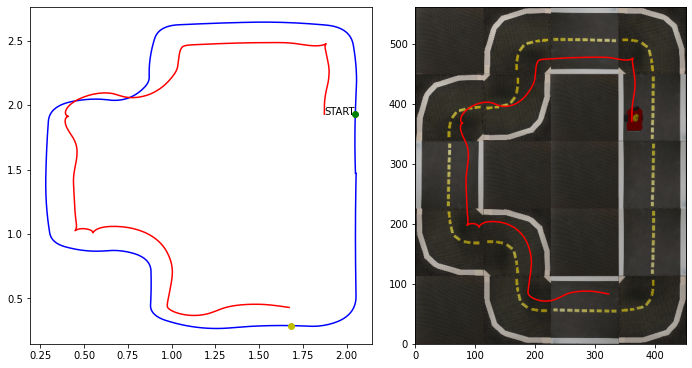

In [32]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC
        AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
# ax_dict["B"].plot(np.arange(len(errors))*dt, np.sqrt(errors))
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

Text(0.5, 0, 'Time (s)')

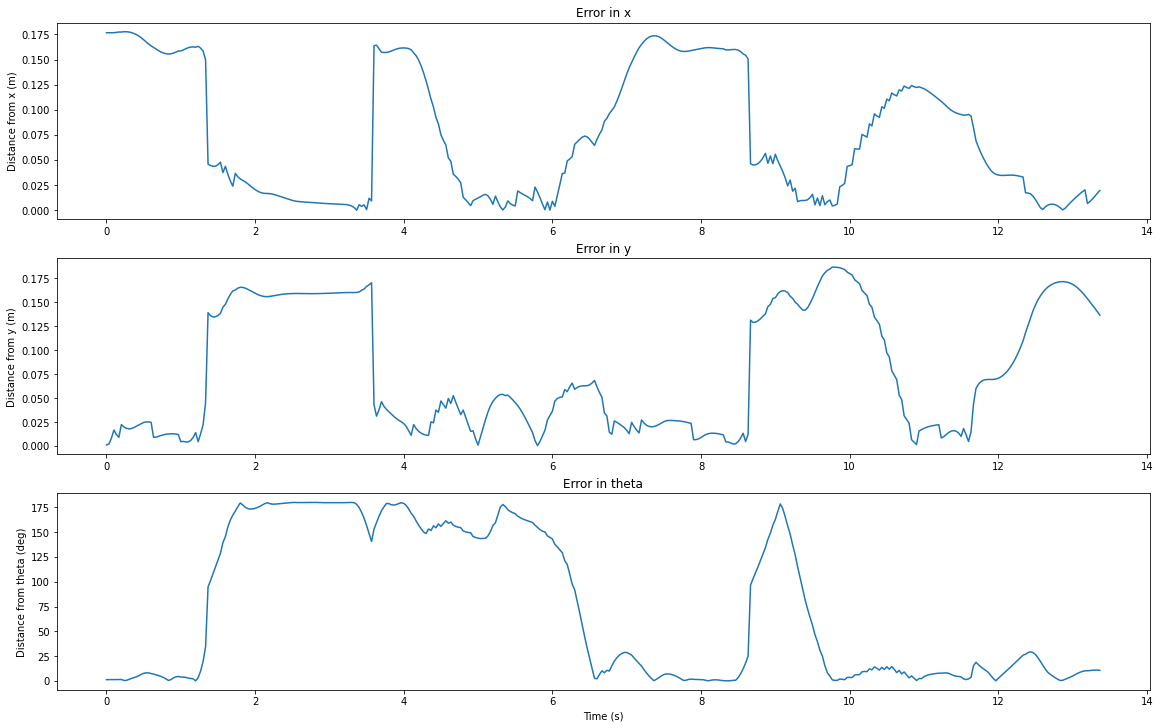

In [33]:
fig = plt.figure(constrained_layout=True, figsize=(16, 10))
ax_dict = fig.subplot_mosaic("""A
        B
        C""")
error_x = np.array(error_x).reshape(-1)
ax_dict["A"].plot(np.arange(len(error_x))*dt, np.abs(error_x))
ax_dict["A"].set_title("Error in x")
ax_dict["A"].set_ylabel("Distance from x (m)")
error_y = np.array(error_y).reshape(-1)
ax_dict["B"].plot(np.arange(len(error_y))*dt, np.abs(error_y))
ax_dict["B"].set_title("Error in y")
ax_dict["B"].set_ylabel("Distance from y (m)")
error_theta_scaled = np.rad2deg(np.array(error_theta).reshape(-1))
ax_dict["C"].plot(np.arange(len(error_theta_scaled))*dt, np.abs(error_theta_scaled))
ax_dict["C"].set_title("Error in theta")
ax_dict["C"].set_ylabel("Distance from theta (deg)")
ax_dict["C"].set_xlabel("Time (s)")

### Gym simulation

The MPC does not consider the delay yet!

In [34]:
record = True

if record:
    import imageio
    import cv2

    env.reset()
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/mpc_run.gif", images, format='GIF', fps=env.frame_rate)

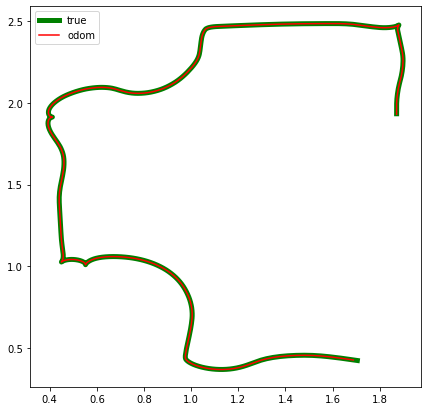

In [35]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

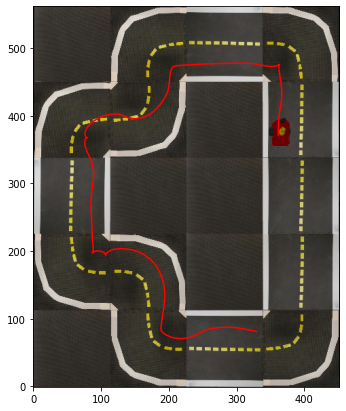

In [36]:
if record:
    utils.show_on_map(env, positions)

In [37]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))